In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader,Subset
from torchvision import transforms,datasets
from torchvision import models
import torch.optim as optim
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
BATCH_SIZE = 32
EPHOCHS = 20
MANUAL_SEED = 42
LEARNING_RATE = 0.001

In [4]:
torch.manual_seed(MANUAL_SEED)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [5]:
dataset = '/kaggle/input/groundnut-mandel/A novel groundnut leaf dataset for detection and classification of groundnut leaf diseases'
dataset1 = datasets.ImageFolder(root=dataset,transform=transform)

In [6]:
import os
classes = os.listdir(dataset)
num_classes = len(classes)
NUM_CLASSES = num_classes

In [7]:
indices = list(range(len(dataset1)))
torch.manual_seed(MANUAL_SEED)
train_indices, test_indices = train_test_split(indices,test_size=0.2,random_state=MANUAL_SEED)

In [8]:
train_dataset = Subset(dataset1,train_indices)
test_dataset = Subset(dataset1,test_indices)

In [9]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [10]:
len(train_dataset)

1376

In [11]:
len(test_dataset)

344

In [12]:
from torchvision.models import ViT_B_16_Weights
model = models.vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 198MB/s]  


In [13]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [14]:
!pip install torchinfo

In [15]:
# Print a summary using torchinfo 
from torchinfo import summary
summary(model=model, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [16]:
# Freeze all layers except the classification head
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classification head
for param in model.heads.head.parameters():
    param.requires_grad = True

In [17]:
# Modify the classification head for your number of classes
num_classes = NUM_CLASSES
model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)

In [18]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [19]:
# Print a summary using torchinfo 
from torchinfo import summary
summary(model=model, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 5]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
from tqdm import tqdm

model = model.to(device)
train_losses = []
test_losses = []

for epoch in range(EPHOCHS):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Training Loop with tqdm
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPHOCHS} [Training]", leave=False)
    for inputs, labels in train_loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update training metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Update progress bar
        train_loop.set_postfix(loss=loss.item(), accuracy=correct_predictions / total_samples * 100)

    # Compute average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    epoch_accuracy = correct_predictions / total_samples * 100

    # Validation Loop with tqdm
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []
    running_test_loss = 0.0

    val_loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPHOCHS} [Validation]", leave=False)
    with torch.no_grad():
        for inputs, labels in val_loop:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Update validation metrics
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predicted.extend(predicted.cpu().numpy())
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            # Update progress bar
            val_loop.set_postfix(loss=loss.item(), accuracy=correct / total * 100)

    # Calculate validation loss and accuracy
    accuracy = 100 * correct / total
    epoch_test_loss = running_test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)

    print(f"Epoch [{epoch+1}/{EPHOCHS}], "
          f"Training Loss: {epoch_loss:.4f}, Testing Loss: {epoch_test_loss:.4f}, "
          f"Training Accuracy: {epoch_accuracy:.2f}%, Testing Accuracy: {accuracy:.2f}%")

Epoch [1/20], Training Loss: 0.9112, Testing Loss: 0.5763, Training Accuracy: 68.02%, Testing Accuracy: 84.59%


Epoch [2/20], Training Loss: 0.4432, Testing Loss: 0.3983, Training Accuracy: 88.15%, Testing Accuracy: 88.08%


Epoch [3/20], Training Loss: 0.3236, Testing Loss: 0.3217, Training Accuracy: 91.50%, Testing Accuracy: 92.15%


Epoch [4/20], Training Loss: 0.2646, Testing Loss: 0.2713, Training Accuracy: 93.60%, Testing Accuracy: 92.44%


Epoch [5/20], Training Loss: 0.2289, Testing Loss: 0.2508, Training Accuracy: 93.90%, Testing Accuracy: 94.48%


Epoch [6/20], Training Loss: 0.2047, Testing Loss: 0.2203, Training Accuracy: 95.13%, Testing Accuracy: 95.64%


Epoch [7/20], Training Loss: 0.1809, Testing Loss: 0.2035, Training Accuracy: 95.93%, Testing Accuracy: 94.77%


Epoch [8/20], Training Loss: 0.1663, Testing Loss: 0.1978, Training Accuracy: 96.37%, Testing Accuracy: 95.35%


Epoch [9/20], Training Loss: 0.1560, Testing Loss: 0.1816, Training Accuracy: 96.44%, Testing Accuracy: 95.93%


Epoch [10/20], Training Loss: 0.1424, Testing Loss: 0.1725, Training Accuracy: 96.66%, Testing Accuracy: 96.22%


Epoch [11/20], Training Loss: 0.1319, Testing Loss: 0.1654, Training Accuracy: 96.95%, Testing Accuracy: 96.22%


Epoch [12/20], Training Loss: 0.1247, Testing Loss: 0.1730, Training Accuracy: 97.17%, Testing Accuracy: 95.93%


Epoch [13/20], Training Loss: 0.1169, Testing Loss: 0.1561, Training Accuracy: 97.38%, Testing Accuracy: 96.80%


Epoch [14/20], Training Loss: 0.1115, Testing Loss: 0.1588, Training Accuracy: 97.53%, Testing Accuracy: 95.64%


Epoch [15/20], Training Loss: 0.1036, Testing Loss: 0.1498, Training Accuracy: 97.82%, Testing Accuracy: 96.80%


Epoch [16/20], Training Loss: 0.0989, Testing Loss: 0.1454, Training Accuracy: 97.97%, Testing Accuracy: 96.80%


Epoch [17/20], Training Loss: 0.0940, Testing Loss: 0.1415, Training Accuracy: 97.89%, Testing Accuracy: 96.80%


Epoch [18/20], Training Loss: 0.0888, Testing Loss: 0.1392, Training Accuracy: 98.04%, Testing Accuracy: 96.80%


Epoch [19/20], Training Loss: 0.0852, Testing Loss: 0.1346, Training Accuracy: 98.04%, Testing Accuracy: 97.38%


Epoch [20/20], Training Loss: 0.0812, Testing Loss: 0.1317, Training Accuracy: 98.18%, Testing Accuracy: 96.80%


In [22]:
# model = model.to(device)
# train_losses = []
# test_losses = []
# for epoch in range(EPHOCHS):
#     model.train()
#     running_loss = 0.0
#     correct_predictions = 0
#     total_samples = 0

#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         # Calculate loss
#         running_loss += loss.item()
#         # Calculate accuracy
#         _, predicted = torch.max(outputs, 1)
#         correct_predictions += (predicted == labels).sum().item()
#         total_samples += labels.size(0)
#     # Compute average loss and accuracy for the epoch
#     epoch_loss = running_loss / len(train_loader)
#     train_losses.append(epoch_loss)
#     epoch_accuracy = correct_predictions / total_samples * 100
#     # Validation loop (testing loss)
#     model.eval()
#     correct = 0
#     total = 0
#     all_labels = []
#     all_predicted = []
#     running_test_loss = 0.0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             # Store the labels and predictions for metric calculation
#             all_labels.extend(labels.cpu().numpy())
#             all_predicted.extend(predicted.cpu().numpy()) 
#             loss = criterion(outputs, labels)
#             running_test_loss += loss.item()
#     # Calculate accuracy
#     accuracy = 100 * correct / total
#     epoch_test_loss = running_test_loss / len(test_loader)
#     test_losses.append(epoch_test_loss)
#     print(f'Epoch [{epoch+1}/{EPHOCHS}], Training Loss: {epoch_loss:.4f}, Testing Loss: {epoch_test_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%, Testing Accuracy: {accuracy:.2f}%')

In [23]:
def predict_image(image_path, model, device):
    image = Image.open(image_path) 
    image = transform(image)  
    image = image.unsqueeze(0)  # Add a batch dimension (for a single image)

    # Move the image tensor to the same device as the model (CPU or GPU)
    image = image.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Turn off gradients to speed up inference and reduce memory usage
    with torch.no_grad():
        outputs = model(image)  
        _, predicted_class = torch.max(outputs, 1)  

    return predicted_class.item() 

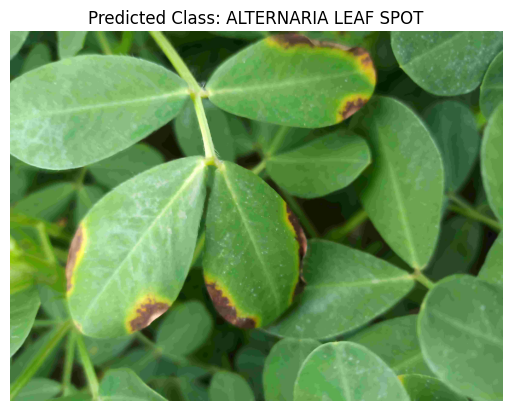

In [31]:
# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) 

image_path = '/kaggle/input/groundnut-mandel/A novel groundnut leaf dataset for detection and classification of groundnut leaf diseases/ALTERNARIA LEAF SPOT/Alternaria Leaf Spot (1).jpg'

# Predict the class
predicted_class = predict_image(image_path, model, device)

# Map the predicted class index to the actual class label (assuming you have a label mapping)
class_names = dataset1.classes 
predicted_label = class_names[predicted_class]

plt.imshow(Image.open(image_path))
plt.title(f'Predicted Class: {predicted_label}')
plt.axis('off')
plt.show()
# print(f'The predicted class is: {predicted_label}')

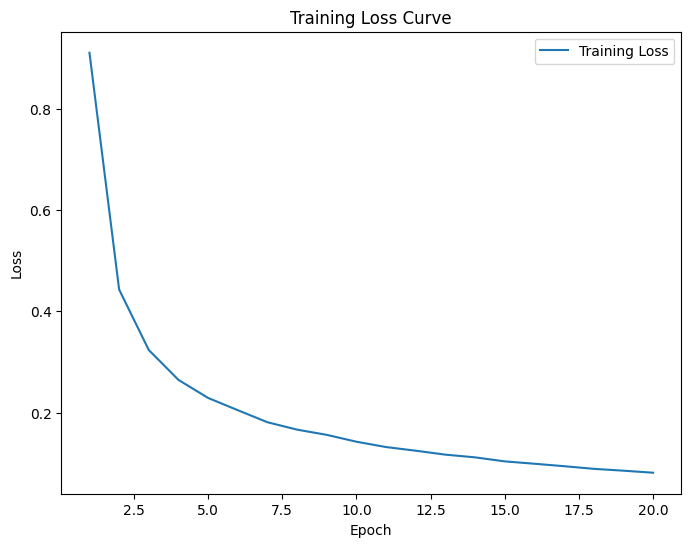

In [33]:
# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, EPHOCHS + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.savefig("Loss_Curve(Training)_sufflenetv2.png",dpi=2000)
plt.show()

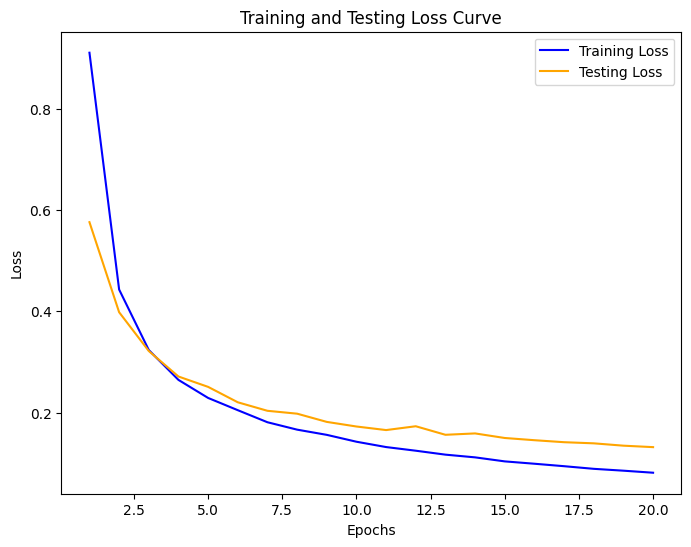

In [32]:
# Plotting training and testing loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, EPHOCHS + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, EPHOCHS + 1), test_losses, label='Testing Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curve')
plt.legend()
plt.savefig("Loss_Curve_sufflenetv2.png",dpi=2000)
plt.show()

In [27]:
model.eval() 
correct1 = 0
total1 = 0
all_labels1 = []
all_predicted1 = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        total1 += labels.size(0)
        correct1 += (predicted == labels).sum().item()

        # Store the labels and predictions for metric calculation
        all_labels1.extend(labels.cpu().numpy())
        all_predicted1.extend(predicted.cpu().numpy())  

# Calculate accuracy
accuracy1 = 100 * correct / total

# Calculate precision, recall, and F1 score
precision = precision_score(all_labels, all_predicted, average='macro')
recall = recall_score(all_labels, all_predicted, average='macro')
f1 = f1_score(all_labels, all_predicted, average='macro')

# Print results
print(f'Test Accuracy: {accuracy1:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Test Accuracy: 96.80%
Precision: 0.98
Recall: 0.96
F1 Score: 0.97


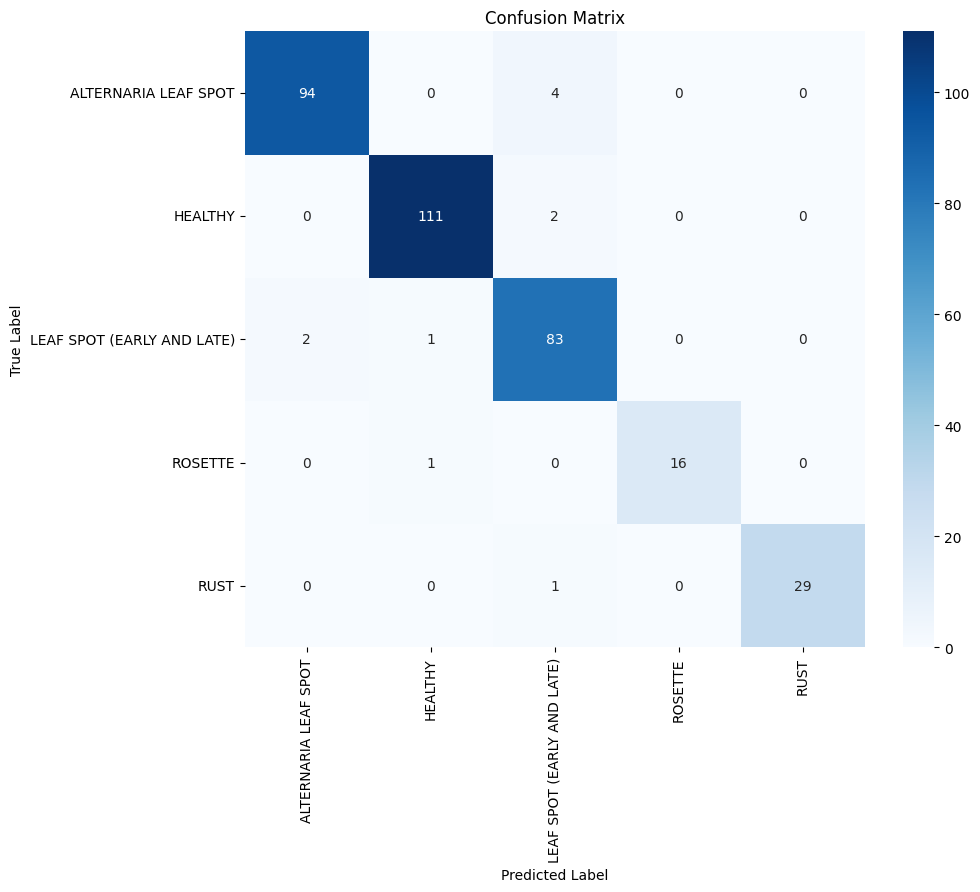

In [34]:
import seaborn as sns
# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)
class_names = dataset1.classes

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig("Confusion_Matrix_sufflenetv2.png",dpi=2000)
plt.show()

In [29]:
# Define a path to save the model
model_save_path = "vit_plant_disease_classifier.pth"

# Save the model's state_dict
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to vit_plant_disease_classifier.pth
